## Annotating rostro-caudal landmarks in H&E images in 10x Visium samples

In [19]:
# initialisation 
import os
import panel as pn
import socket
import numpy as np
import tissue_tag as tt
os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "*"
host = '5011' # set the port to the value in the address bar when operating in farm

In [20]:
data_dir = "/nfs/team292/vl6/FetalReproductiveTract/VISIUM/data/"
sample = "HCA_F_RepTsp13902018"

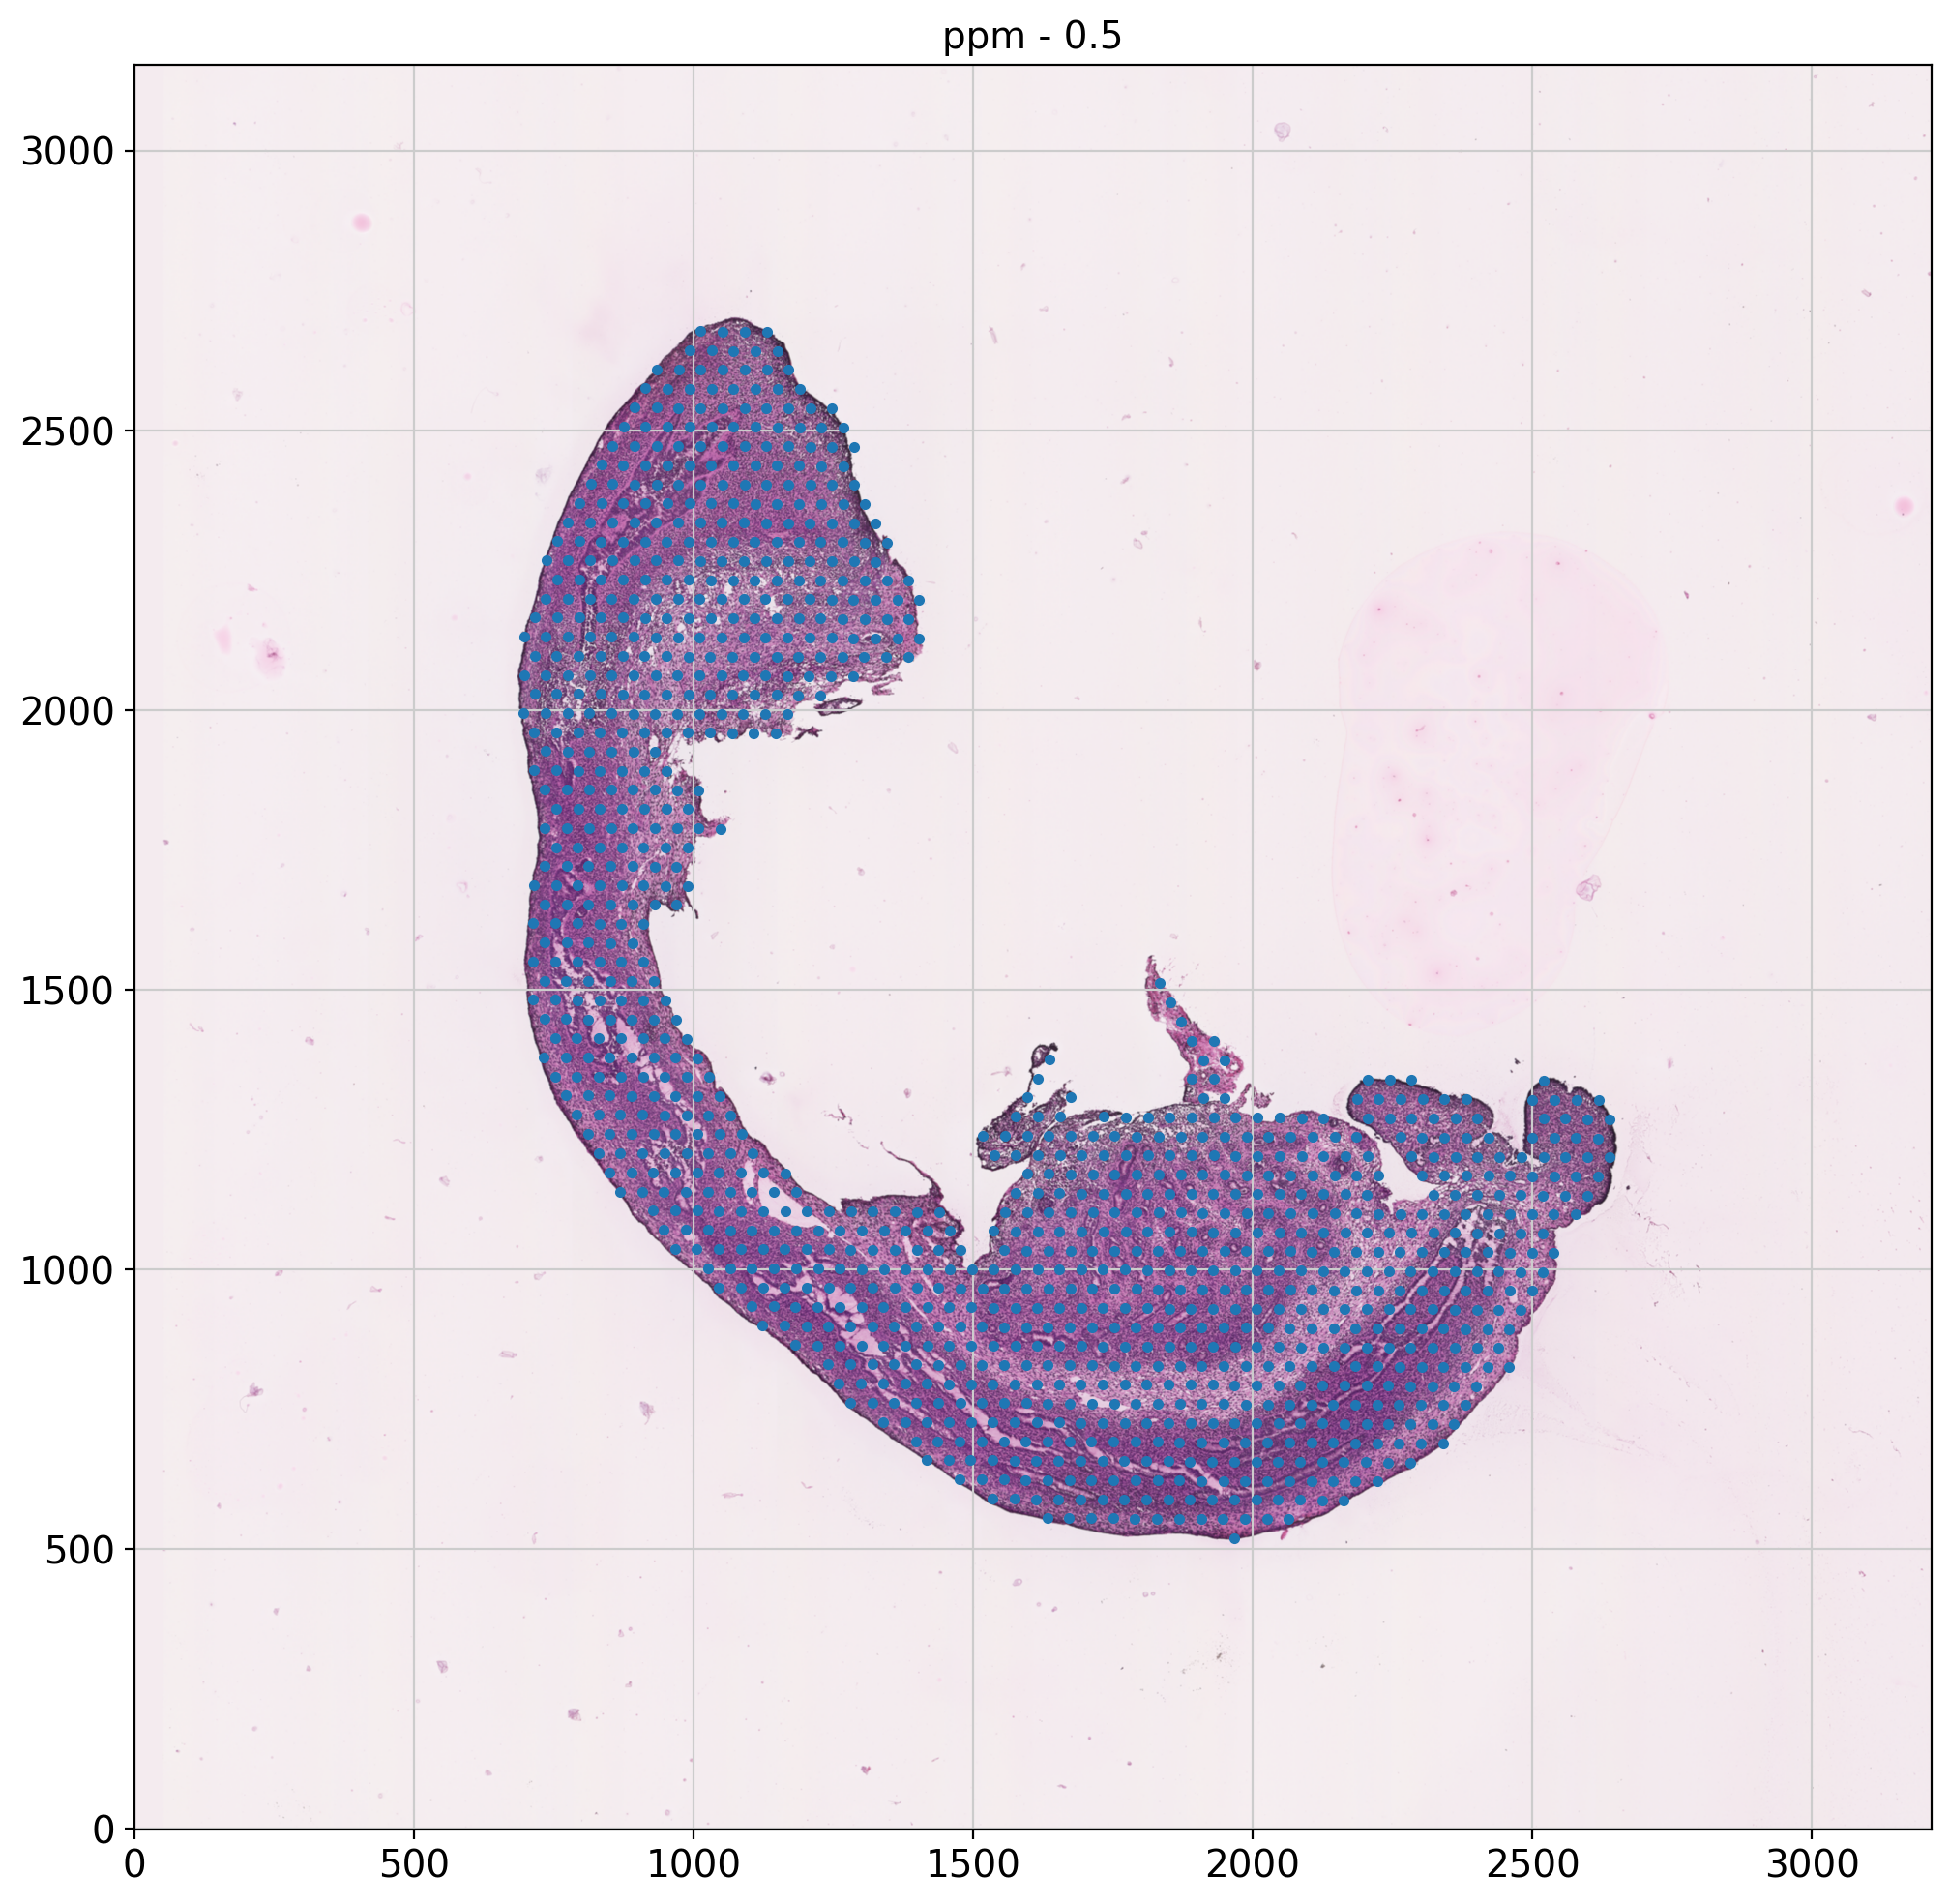

In [21]:
im,ppm_anno,df = tt.read_visium(spaceranger_dir_path=data_dir+sample+'/',use_resolution='hires',res_in_ppm=0.5)

In [22]:
# define annotations 
annodict = {
    'Unassigned': 'gray',
    'FallopianFimbriae': 'orange', 
    'FallopianUterineJunction': 'red', 
    'UterineFundus': 'blue', 
    'UterineBottom': 'yellowgreen', 
    'EndodermalVaginalStart': 'forestgreen', 
    'EfferentDuctules': 'darkcyan', 
    'EpididymisEnd': 'violet', 
}
labels = np.zeros((im.shape[0],im.shape[1]), dtype=np.uint8) # blank annotation image canvas

In [23]:
# use annotator to label tissue regions according to categories indicated above
annotator,render_dict = tt.annotator(im,labels,anno_dict=annodict,use_datashader=True)
pn.io.notebook.show_server(annotator, notebook_url=f'node-11-2-4:'+host)

Unassigned
FallopianFimbriae
FallopianUterineJunction


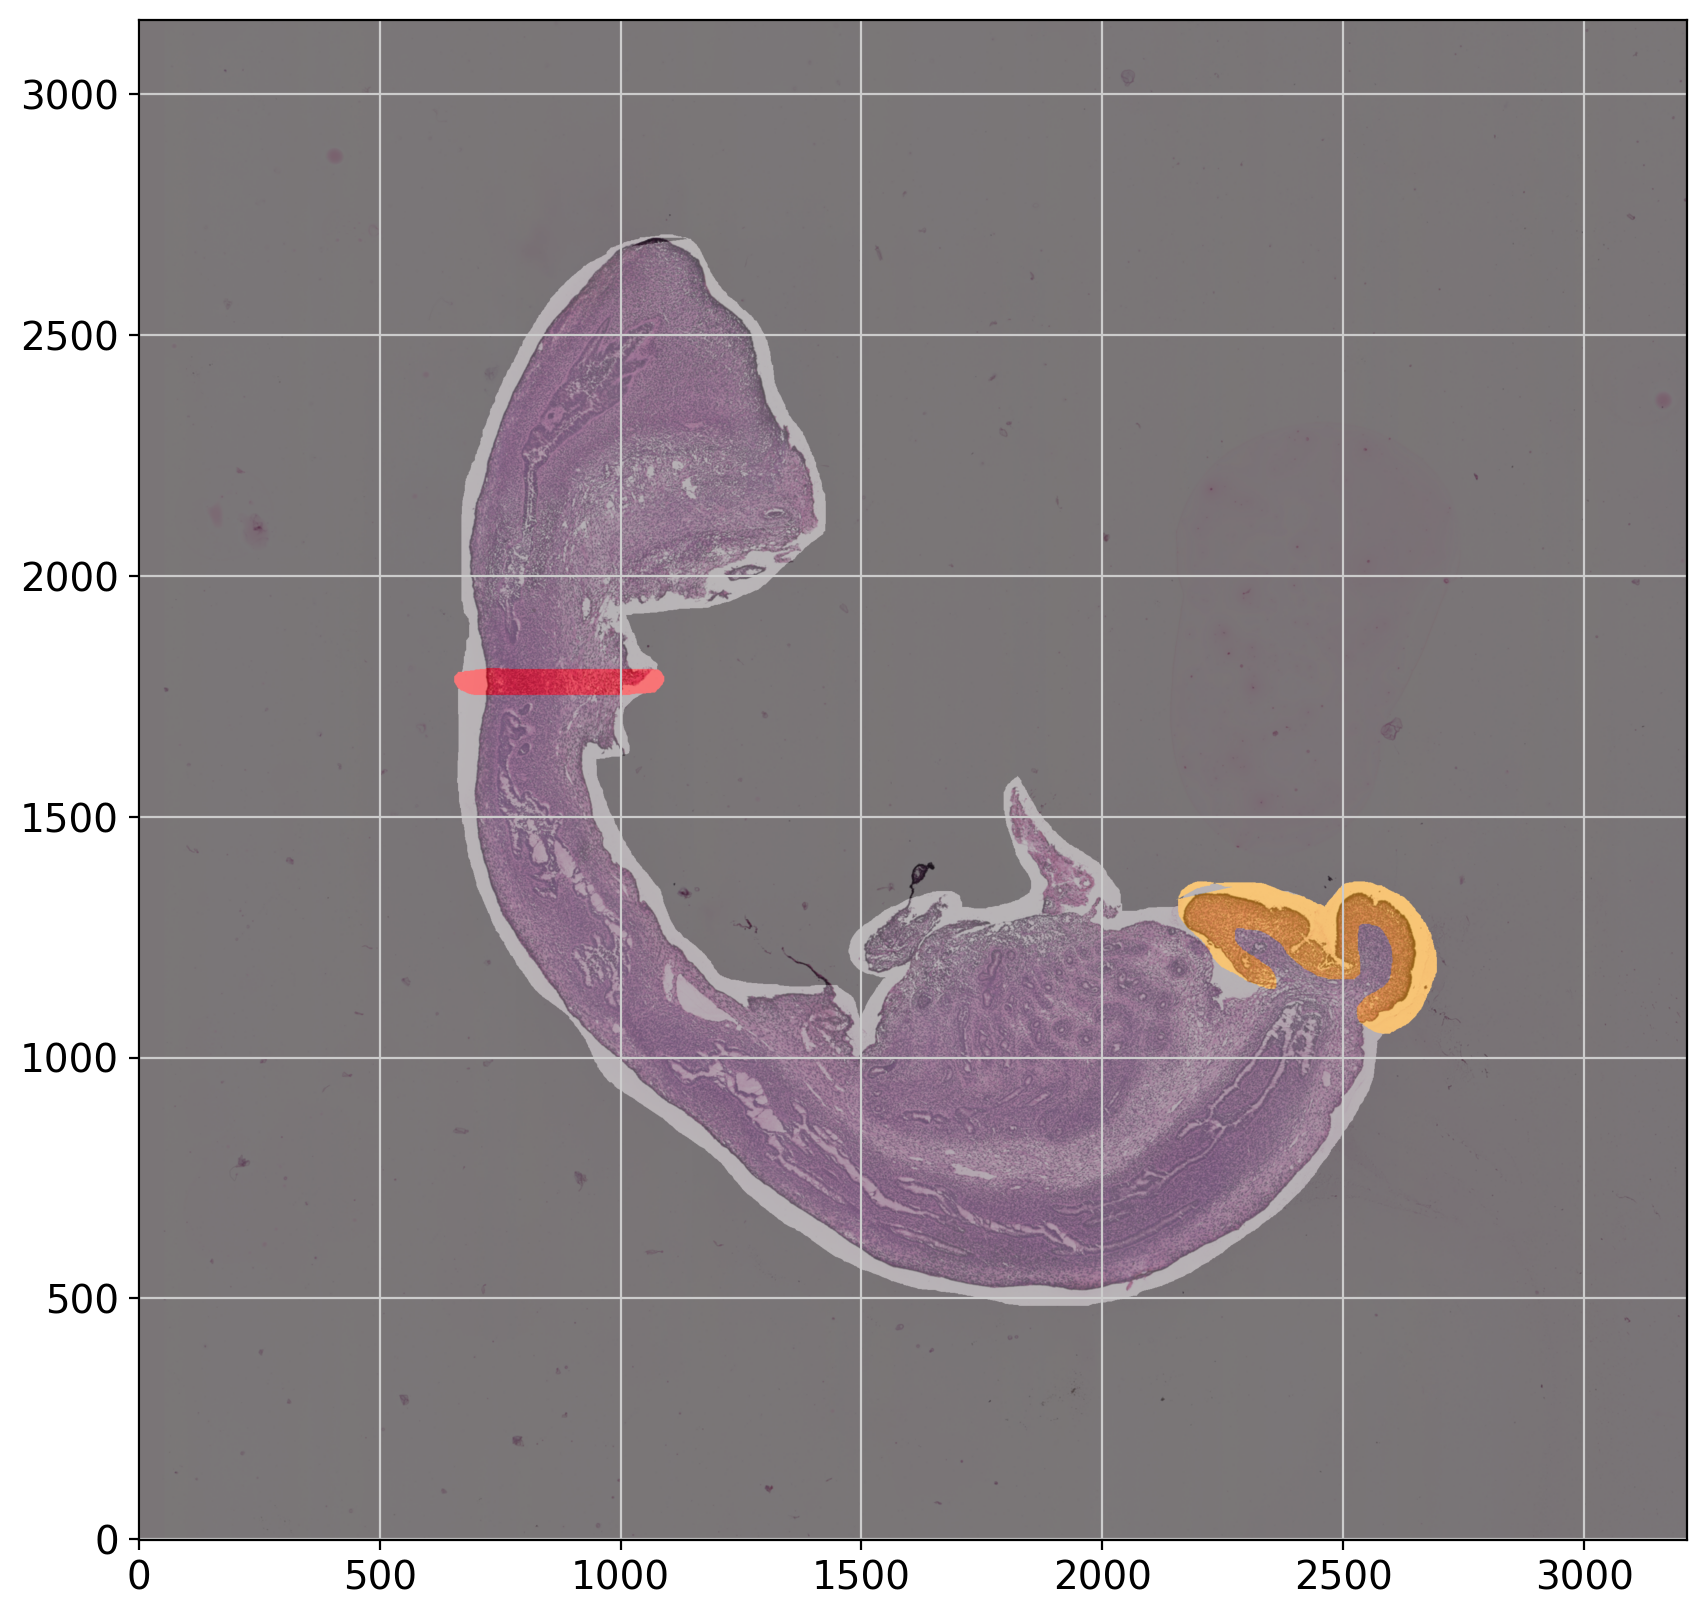

In [24]:
# This step fills in the shapes created for the pixel classifier

labels = tt.update_annotator(
    imarray=im,
    labels=labels,
    anno_dict=annodict,
    render_dict=render_dict
)

In [25]:
isExist = os.path.exists(data_dir+sample+'/'+'tissue_annotations')
if not(isExist):
    os.mkdir(data_dir+sample+'/tissue_annotations/')
    
tt.save_annotation(
    folder=data_dir+sample+'/tissue_annotations/',
    label_image=labels,
    file_name='rostrocaudal_annotations',
    anno_names=list(annodict.keys()),
    anno_colors=list(annodict.values()),
    ppm = ppm_anno
)

### Load annotations names and colors

In [26]:
# load tissue annotations from TissueTag and migrate annotation to a 15um hexagonal grid and outputs the coordinates in ppm=1 

df_anno = tt.anno_to_grid(
    folder=data_dir+sample+'/tissue_annotations/',
    file_name = 'rostrocaudal_annotations',
    spot_to_spot = 15, # this determines the grid density in microns
    load_colors=True,
)
df_anno['rostrocaudal_annotations'].value_counts()

loaded annotation image - rostrocaudal_annotations size - (3155, 3214)
loaded annotations
{1: 'Unassigned', 2: 'FallopianFimbriae', 3: 'FallopianUterineJunction', 4: 'UterineFundus', 5: 'UterineBottom', 6: 'EndodermalVaginalStart', 7: 'EfferentDuctules', 8: 'EpididymisEnd'}
loaded ppm
{'ppm': 0.5}
loaded color annotations
{'Unassigned': 'gray', 'FallopianFimbriae': 'orange', 'FallopianUterineJunction': 'red', 'UterineFundus': 'blue', 'UterineBottom': 'yellowgreen', 'EndodermalVaginalStart': 'forestgreen', 'EfferentDuctules': 'darkcyan', 'EpididymisEnd': 'violet'}
Generating grid with spacing - 15, from annotation resolution of - 0.5 ppm


rostrocaudal_annotations
Unknown                     169258
Unassigned                   34649
FallopianFimbriae             1766
FallopianUterineJunction       475
Name: count, dtype: int64

In [28]:
print('calculating distances')
tt.dist2cluster_fast(
    df=df_anno,
    annotation='rostrocaudal_annotations',
    KNN=10
    ) # calculate minimum mean distance of each spot to clusters

calculating distances
calculating distance matrix with cKDTree
FallopianFimbriae
FallopianUterineJunction
Unassigned
Unknown


{'FallopianFimbriae': array([5025.35948428, 5017.74898653, 5010.17183544, ..., 3765.06590204,
        3779.22331453, 3793.38720259]),
 'FallopianUterineJunction': array([3764.92540535, 3750.93301084, 3736.9484331 , ..., 5011.83415714,
        5019.86594225, 5027.92964687]),
 'Unassigned': array([2713.89421555, 2703.4403097 , 2693.02936353, ..., 3932.86287581,
        3947.00262436, 3961.14869469]),
 'Unknown': array([26.10203332, 20.19615242, 19.79422863, ..., 19.79422863,
        20.19615242, 26.10203332])}

### Map annotations to 10x Visium spots via spatial kNN

<Figure size 1200x1200 with 0 Axes>

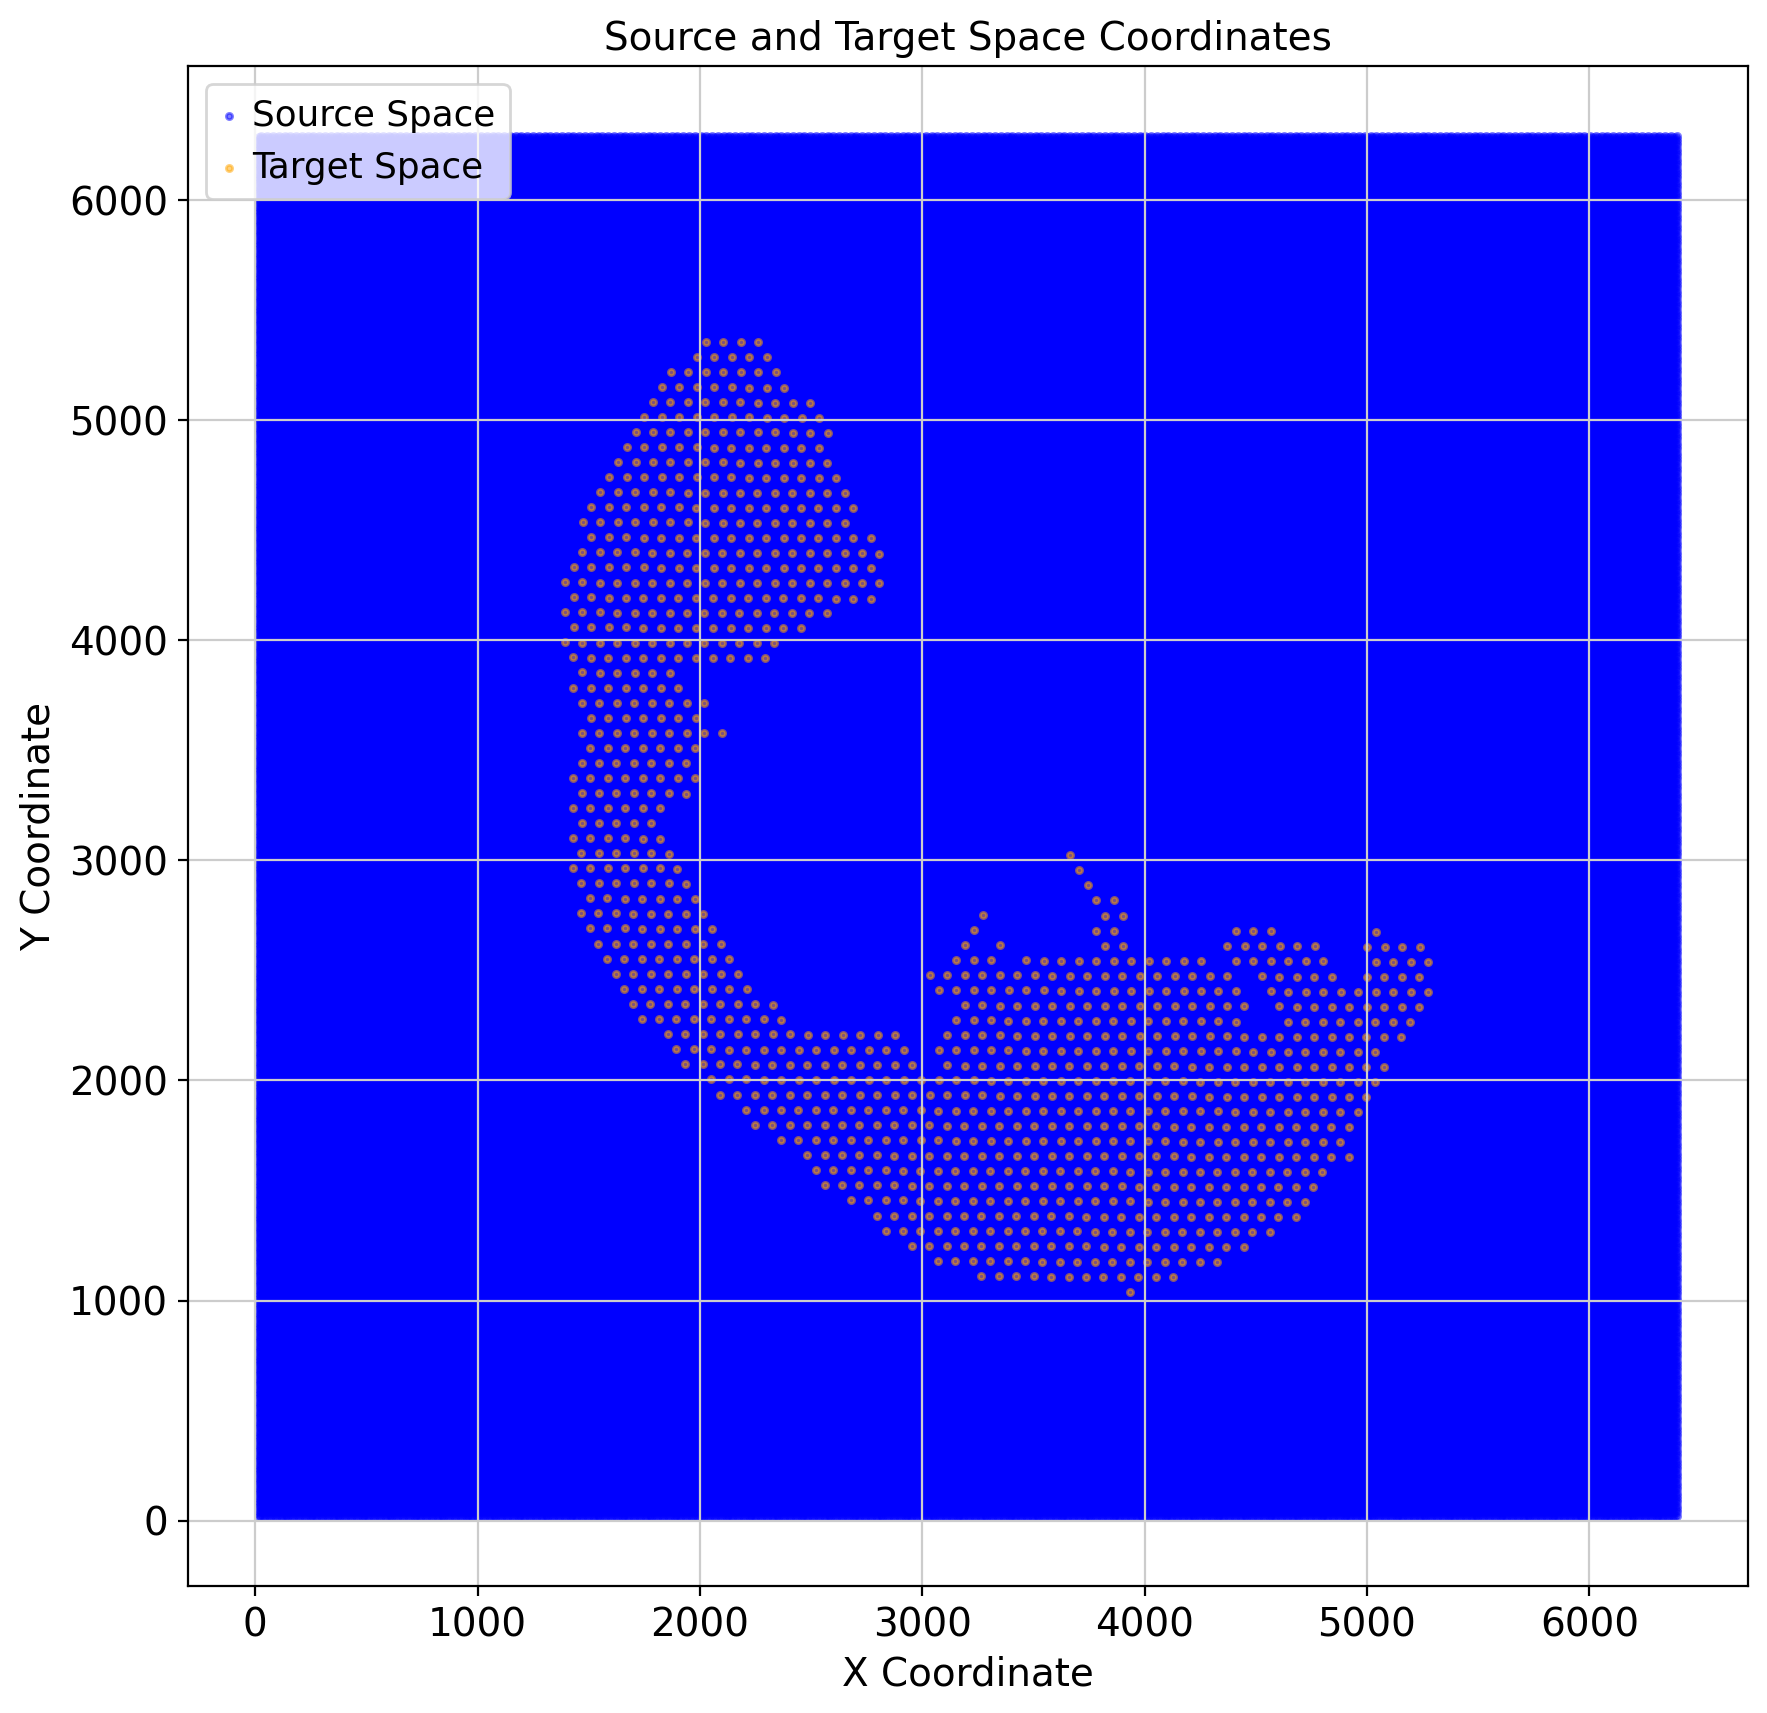

In [29]:
# read visium info and map annotations  - make sure the 2 grids seem aligned
_,ppm_vis,vis_df = tt.read_visium(spaceranger_dir_path=data_dir+sample+'/',plot=False)
vis_df.rename(columns={'pxl_col': "x", 'pxl_row': "y"},inplace=True) # for new spaceranger adjust for any DF not only for visium
vis_df = tt.map_annotations_to_target(                            
    df_target=vis_df,  
    df_source=df_anno,
    ppm_target= ppm_vis,
    plot=True,
)

In [42]:
# read visium full data 
import scanpy as sc
adata_vis = sc.read(data_dir+sample+'/'+sample+'_annotated.h5ad')
adata_vis.var_names_make_unique()

/software/cellgen/team292/vl6/envs/tissue-tag-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [43]:
import pandas as pd

In [44]:
# add rostro-caudal annotations to anatomical annotations but first remove duplicate obs
del adata_vis.obs['x']
del adata_vis.obs['y']
del adata_vis.obs['pxl_row_in_fullres']
del adata_vis.obs['pxl_col_in_fullres']

In [45]:
# Align indices between adata_vis.obs and df_visium_spot
df_visium_spot_aligned = vis_df.iloc[:, 3:].reindex(adata_vis.obs.index)
adata_vis.obs = pd.concat([adata_vis.obs,vis_df.iloc[:,2:]],axis=1)
adata_vis.obsm['spatial'] = adata_vis.obsm['spatial'].astype('int')
adata_vis

AnnData object with n_obs × n_vars = 4992 × 37082
    obs: 'in_tissue', 'array_row', 'array_col', 'L2_dist_anatomical_annotations_FallopianTube', 'L2_dist_anatomical_annotations_Unknown', 'L2_dist_anatomical_annotations_Uterus', 'L2_dist_anatomical_annotations_WolffianRemnants', 'anatomical_annotations', 'anatomical_annotations_number', 3, 4, 5, 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'x', 'y', 'L2_dist_rostrocaudal_annotations_FallopianFimbriae', 'L2_dist_rostrocaudal_annotations_FallopianUterineJunction', 'L2_dist_rostrocaudal_annotations_Unassigned', 'L2_dist_rostrocaudal_annotations_Unknown', 'rostrocaudal_annotations', 'rostrocaudal_annotations_number'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'anatomical_annotations_colors', 'spatial'
    obsm: 'spatial'

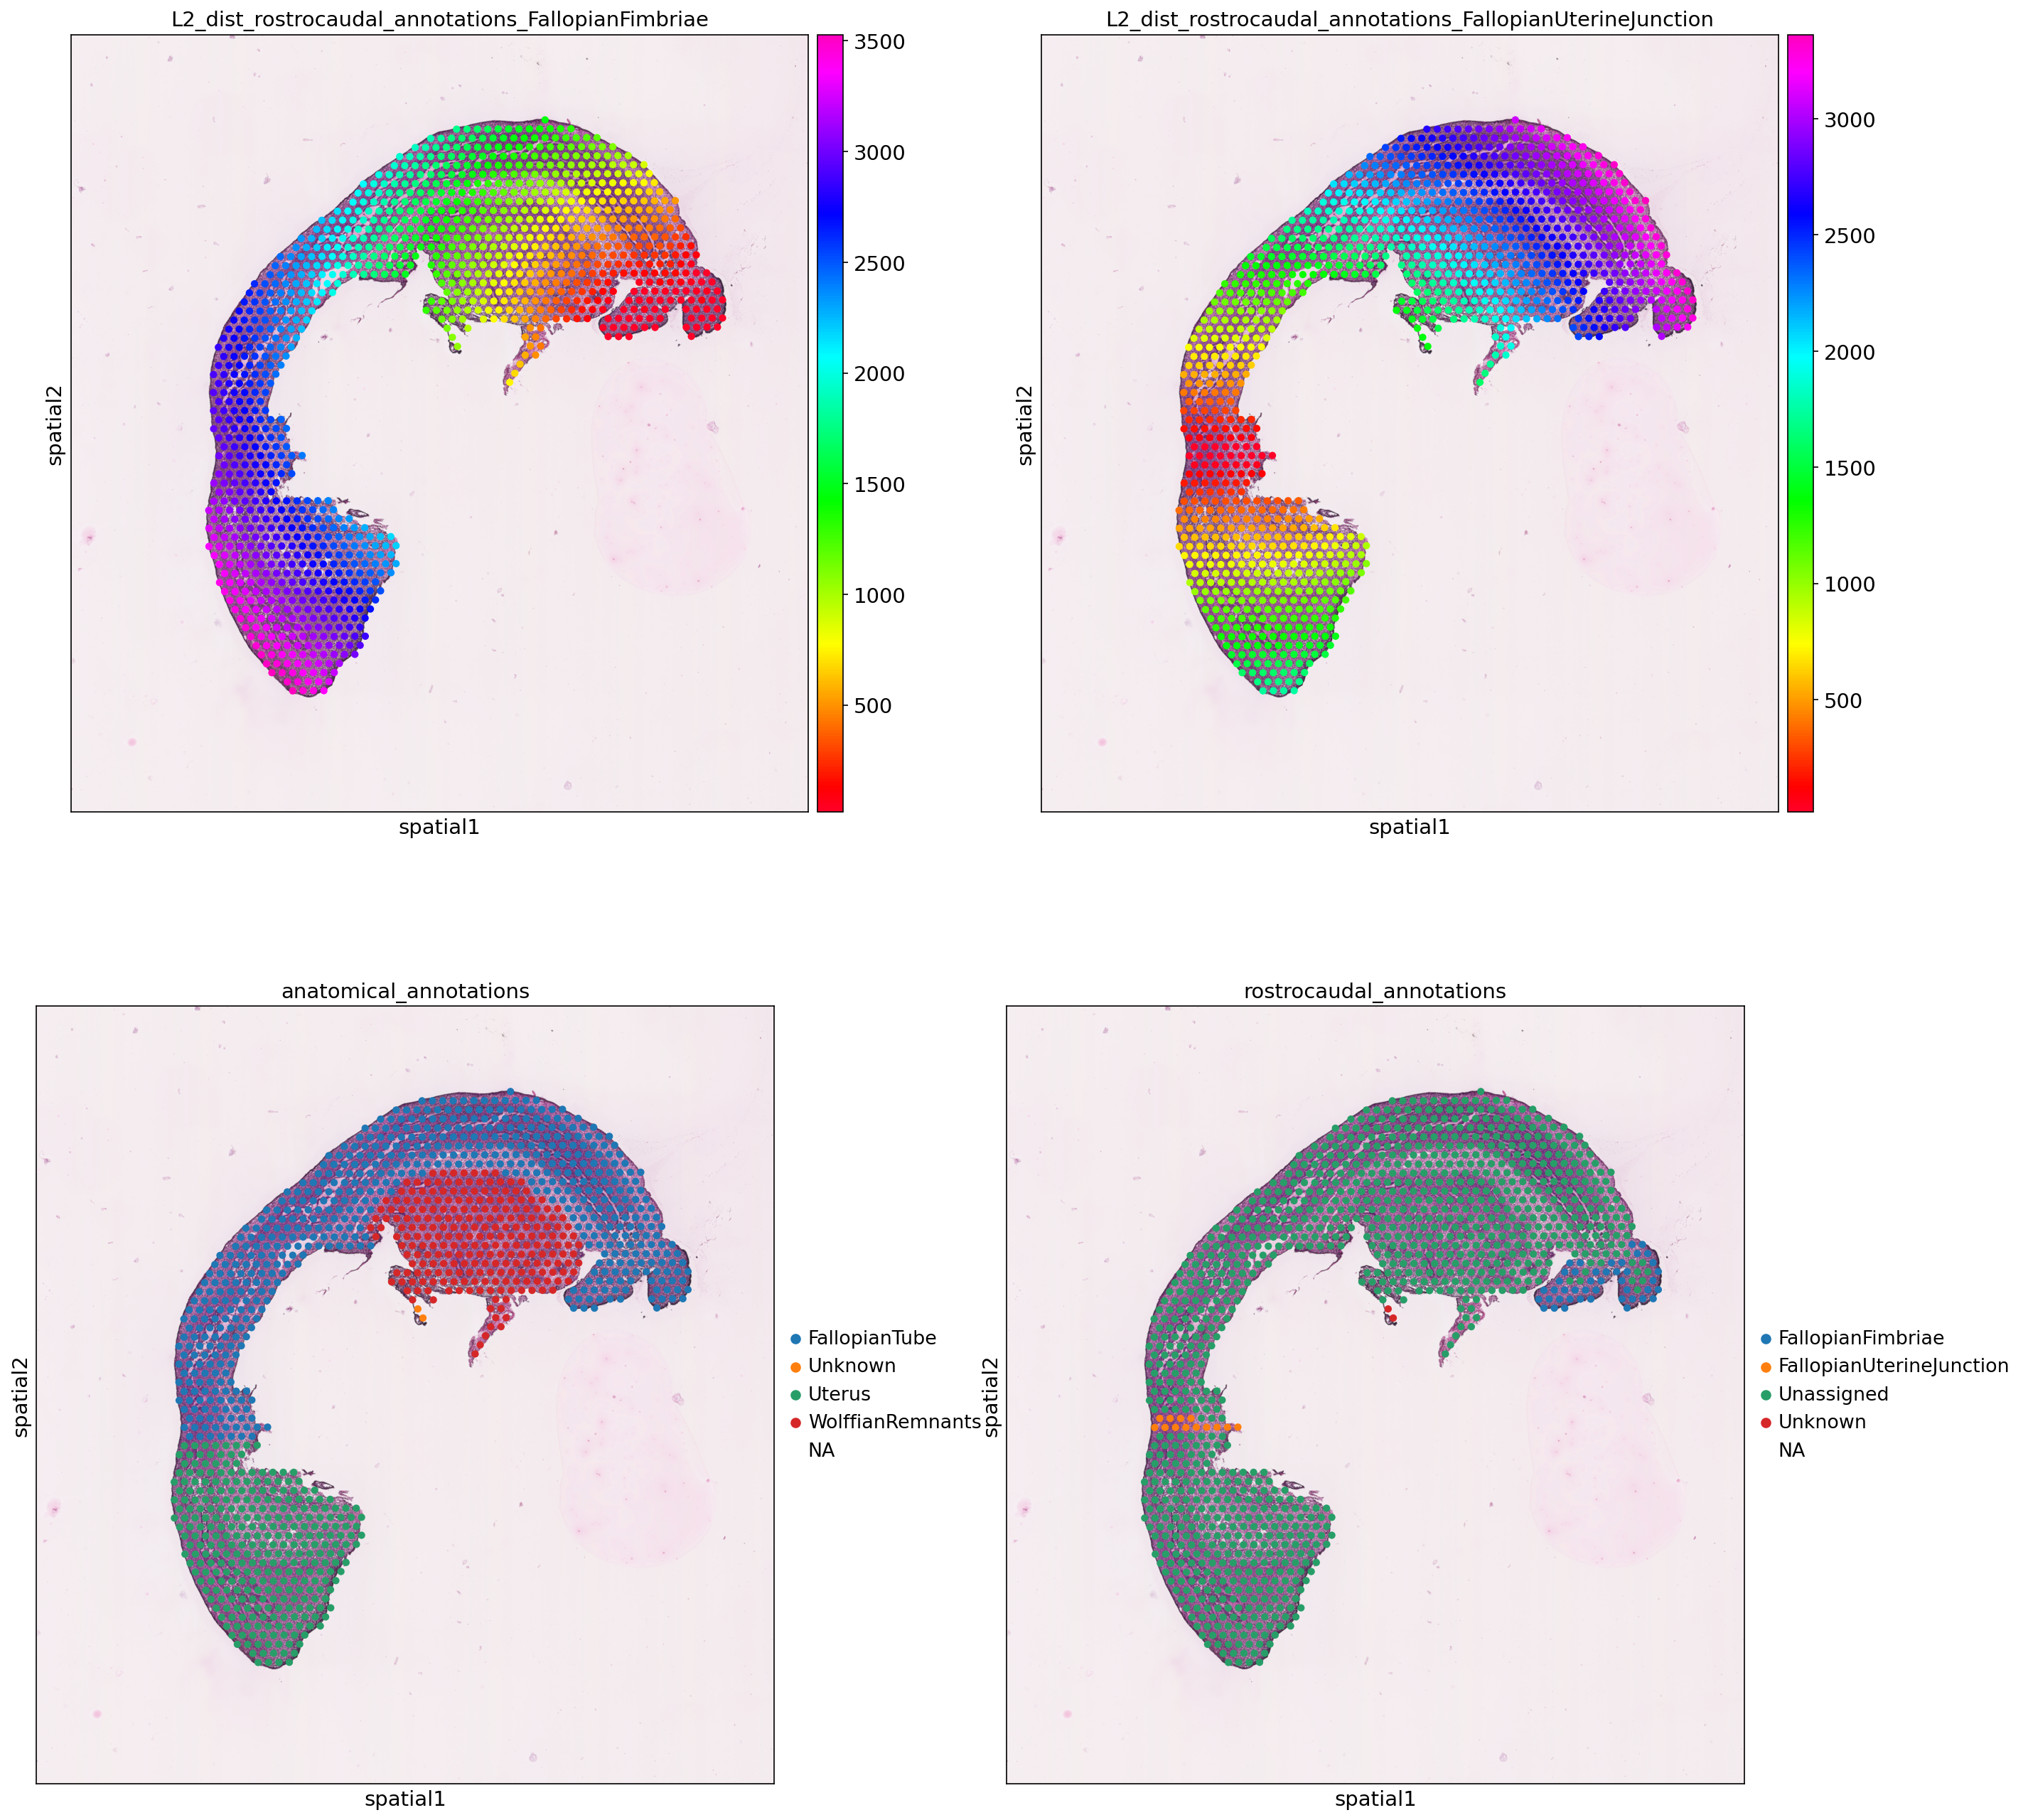

In [46]:
# plot the newly annotated visium AnnData
sc.set_figure_params(figsize=[10,10],dpi=75)
sc.pl.spatial(adata_vis,color=['L2_dist_rostrocaudal_annotations_FallopianFimbriae', 'L2_dist_rostrocaudal_annotations_FallopianUterineJunction',
                              'anatomical_annotations', 'rostrocaudal_annotations']
              ,cmap='gist_rainbow',ncols=2)

In [47]:
del adata_vis.obs[3]
del adata_vis.obs[4]
del adata_vis.obs[5]


In [48]:
adata_vis.write(data_dir+sample+'/'+sample+'_annotated.h5ad')